### **Dependencies**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import re

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

### **Parameters**

In [ ]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
BATCH_SIZE = 1
EPOCHS = 25
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4

HEIGHT_RESIZE = 128
WIDTH_RESIZE = 128
TRANSFORMER_BLOCKS = 6

### **Load data**

In [ ]:
GCS_PATH = '../input/gan-getting-started'
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')

In [ ]:
def normalize_img(image):
    image = tf.cast(image, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (image / 127.5) - 1.0

# takes an image in tensor datatype and returns after reshaping it.
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

# takes a file and parse to get required variables.
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# reads the TFRecords file and maps with the help of read_tfrecord function.
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset
    
def get_dataset(filenames, augment=None, repeat=True, shuffle=True, batch_size=1):
    dataset = load_dataset(filenames)

    if augment:
        dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)

    dataset = dataset.map(normalize_img, num_parallel_calls=AUTOTUNE)

    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(512)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

In [ ]:
monet_ds = get_dataset(MONET_FILENAMES,augment=None, repeat=False, shuffle=False, batch_size=BATCH_SIZE)
photo_ds = get_dataset(PHOTO_FILENAMES,augment=None, repeat=False, shuffle=False, batch_size=BATCH_SIZE)

In [ ]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### **Build the generator**

The `generator` is responsible for generating images from a specific domain. `CycleGAN` architecture has two generators, in this context we will have one `generator` that will take `photos` and generate `Monet paints`, and the other `generator` will take `Monet paintings` and `generate photos.`

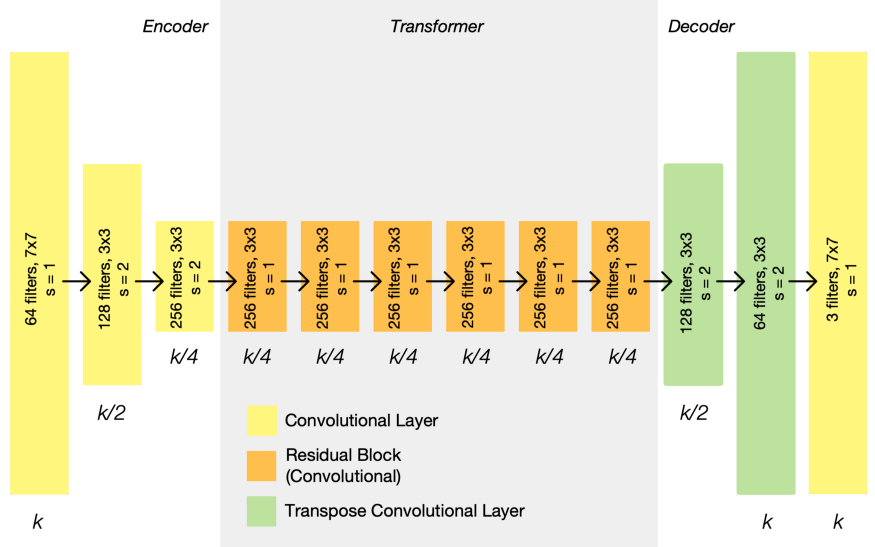
An architecture for a CycleGAN generator. As you can see above, the representation size shrinks in the encoder phase, stays constant in the transformer phase, and expands again in the decoder phase. The representation size that each layer outputs is listed below it, in terms of the input image size, k. On each layer is listed the number of filters, the size of those filters, and the stride. Each layer is followed by an instance normalization and ReLU activation.

In [ ]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Encoder block: Apply convolutional filters while also reducing data resolution and increasing features.
def encoder_block(input_layer, filters, size, stride, apply_instancenorm=True, activation = layers.ReLU()):

    block = layers.Conv2D(filters, kernel_size=size, strides=stride, padding="same", use_bias=False, kernel_initializer=conv_initializer)(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = activation(block)
    return block

In [ ]:
# Transformer block: Apply convolutional filters to find relevant data patterns and keeps features constant.
def transform_block(input_layer, filters, size, stride):

    block = layers.Conv2D(filters, kernel_size=size, strides=stride, padding="same", use_bias=False, kernel_initializer=conv_initializer)(input_layer)
    block = layers.ReLU()(block)
    block = layers.Conv2D(filters, kernel_size=size, strides=stride, padding="same", use_bias=False, kernel_initializer=conv_initializer)(input_layer)
    block = layers.Add()([block, input_layer])   

    return block

In [ ]:
# Decoder block: Apply convolutional filters while also increasing data resolution and decreasing features.
def decoder_block(input_layer, filters, size, stride, apply_instancenorm=True, activation = layers.ReLU()):

    block = layers.Conv2DTranspose(filters, kernel_size=size, strides=stride, padding="same", use_bias=False, kernel_initializer=conv_initializer)(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = activation(block)
    return block

In [ ]:
def Generator():

    inputs = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    # Encoders
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=layers.ReLU())
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=layers.ReLU())
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=layers.ReLU())

    temp = enc_3
    # Transforms
    for i in range(TRANSFORMER_BLOCKS):
        temp = transform_block(temp, 256, 3, 1)
    
    # Decoders
    dec_1 = decoder_block(temp, 128, 3, 2, apply_instancenorm=True, activation=layers.ReLU())
    dec_2 = decoder_block(dec_1, 64, 3, 2, apply_instancenorm=True, activation=layers.ReLU())
    
    outputs = layers.Conv2DTranspose(CHANNELS, 7, strides=1, padding='same', activation='tanh')(dec_2)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

### **Build the discriminator**

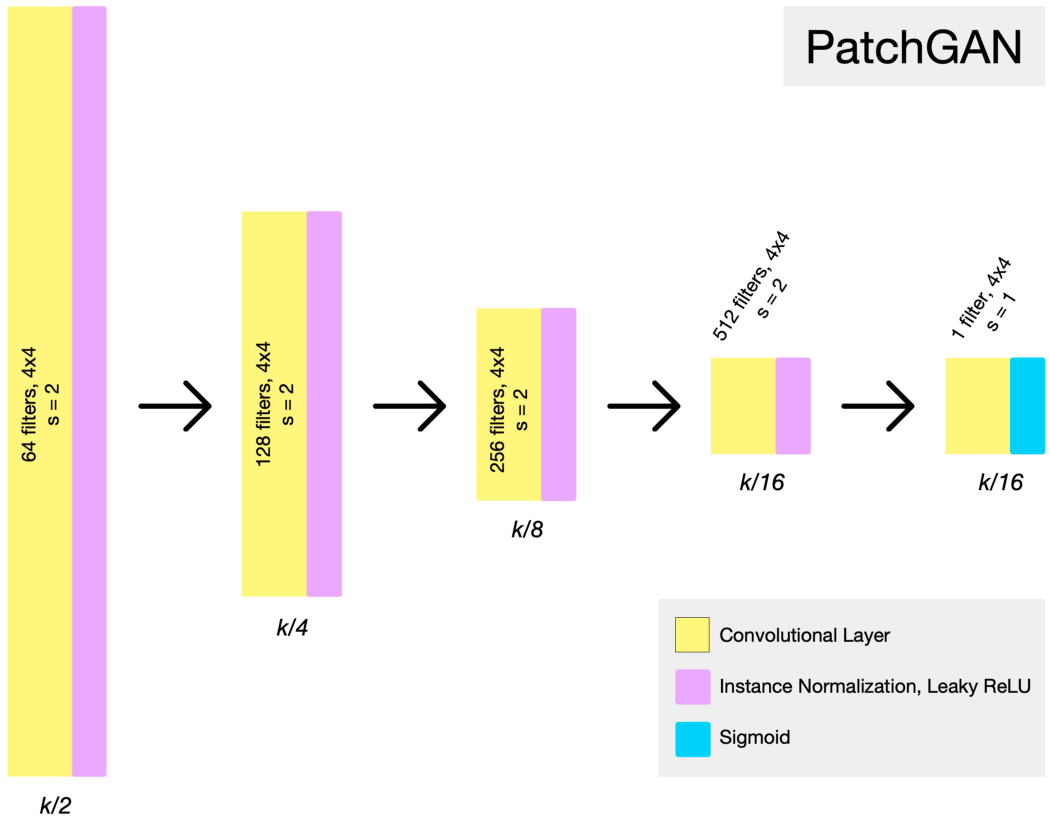
An example architecture for a PatchGAN discriminator. PatchGAN is a fully convolutional network, that takes in an image, and produces a matrix of probabilities, each referring to the probability of the corresponding “patch” of the image being “real” (as opposed to generated). The representation size that each layer outputs is listed below it, in terms of the input image size, k. On each layer is listed the number of filters, the size of those filters, and the stride.

In [ ]:
def Discriminator():

    inputs = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    temp = encoder_block(inputs, 64, 4, 2, apply_instancenorm=False, activation=layers.LeakyReLU(0.2))  
    temp = encoder_block(temp, 128, 4, 2, apply_instancenorm=True, activation=layers.LeakyReLU(0.2))
    temp = encoder_block(temp, 256, 4, 2, apply_instancenorm=True, activation=layers.LeakyReLU(0.2))
    temp = encoder_block(temp, 512, 4, 1, apply_instancenorm=True, activation=layers.LeakyReLU(0.2))

    outputs = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid", kernel_initializer=conv_initializer)(temp)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [ ]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

In [ ]:
monet_discriminator.summary()

In [ ]:
monet_generator.summary()

### **Build the CycleGAN model**

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### **Define loss functions**

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

### **Train the CycleGAN**

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(GENERATOR_LR, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(GENERATOR_LR, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(DISCRIMINATOR_LR, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(DISCRIMINATOR_LR, beta_1=0.5)

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS
    # steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
)

### **Save Models and History**

In [ ]:
import pickle

monet_generator.save('gen_monet.h5')
photo_generator.save('gen_photo.h5')
monet_discriminator.save('disc_monet.h5')
photo_discriminator.save('disc_photo.h5')

with open('history.pkl','wb') as f:
    pickle.dump(history.history, f)

### **Load Models and History**

In [ ]:
import pickle

gen_monet = tf.keras.models.load_model('./gen_monet.h5')
gen_photo = tf.keras.models.load_model('./gen_photo.h5')
disc_monet = tf.keras.models.load_model('./disc_monet.h5')
disc_photo = tf.keras.models.load_model('./disc_photo.h5')

with (open("./history.pkl", "rb")) as openfile:
    history = pickle.load(openfile)

### **Visualize predictions**

In [ ]:
def display_generated_samples(ds, monet_generator, photo_generator,n_samples):
    ds_iter = iter(ds)
    f,ax = plt.subplots(n_samples,3, figsize=(22,n_samples*6))
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = monet_generator.predict(example_sample)
        cycledphoto_sample = photo_generator.predict(generated_sample)
 
        ax[n_sample,0].set_title("Input image")
        ax[n_sample,0].axis('off')
        ax[n_sample,0].imshow(example_sample[0]  * 0.5 + 0.5)
 
        ax[n_sample,1].set_title("Generated image")
        ax[n_sample,1].axis('off')
        ax[n_sample,1].imshow(generated_sample[0] * 0.5 + 0.5)
 
        ax[n_sample,2].set_title("Cycled image")
        ax[n_sample,2].axis('off')
        ax[n_sample,2].imshow(cycledphoto_sample[0] * 0.5 + 0.5)

In [ ]:
display_generated_samples(photo_ds, gen_monet, gen_photo, 8)

In [ ]:
def plot_acc_and_loss(history, load=False):
    monet_g = []
    photo_g = []
    monet_d = []
    photo_d = []

    if load == False:
        history = history.history
    
    for i in range(np.array(history["monet_gen_loss"]).shape[0]):
            monet_g.append(np.array(history["monet_gen_loss"][i]).squeeze().mean())
            photo_g.append(np.array(history["photo_gen_loss"][i]).squeeze().mean())
            monet_d.append(np.array(history["monet_disc_loss"][i]).squeeze().mean())
            photo_d.append(np.array(history["photo_disc_loss"][i]).squeeze().mean())
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(monet_g,label="Monet")
    axs[0].plot(photo_g,label="Photo")
    axs[0].set_title("generator loss")
    axs[0].legend()

    axs[1].plot(monet_d, label="Monet")
    axs[1].plot(photo_d,label="Photo")
    axs[1].set_title("discriminator loss")
    axs[1].legend()

    plt.show()

In [ ]:
plot_acc_and_loss(history, load=True)

### 1. Add skip connections

In [ ]:
def Generator_with_skip_connections():

    inputs = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    # Encoders
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=layers.ReLU())
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=layers.ReLU())
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=layers.ReLU())

    x = enc_3
    # Transforms
    for i in range(TRANSFORMER_BLOCKS):
        x = transform_block(x, 256, 3, 1)
    
    # Decoders

    x_skip = layers.Concatenate(name='enc_dec_skip_1')([x, enc_3]) # encoder - decoder skip connection
    
    dec_1 = decoder_block(x_skip, 128, 3, 2, apply_instancenorm=True) 
    x_skip = layers.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2]) # encoder - decoder skip connection
    
    dec_2 = decoder_block(x_skip, 64,  3, 2, apply_instancenorm=True) 
    x_skip = layers.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1]) # encoder - decoder skip connection

    outputs = layers.Conv2DTranspose(CHANNELS, 7, strides=1, padding='same', activation='tanh')(x_skip)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

def create_adam_optimizers():

    monet_generator_optimizer = tf.keras.optimizers.Adam(GENERATOR_LR, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(GENERATOR_LR, beta_1=0.5)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(DISCRIMINATOR_LR, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(DISCRIMINATOR_LR, beta_1=0.5)

    return monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer

def create_cycle_gan_model(monet_generator, photo_generator,monet_discriminator, photo_discriminator, 
                           monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer):
  
    cycle_gan_model = CycleGan(
      monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

    return cycle_gan_model

In [ ]:
monet_generator = Generator_with_skip_connections() # transforms photos to Monet-esque paintings
photo_generator = Generator_with_skip_connections() # transforms Monet paintings to be more like photos
monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos

monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer = create_adam_optimizers()

cycle_gan_model = create_cycle_gan_model(monet_generator, photo_generator,monet_discriminator, photo_discriminator, 
                                         monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer)

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS
)

In [ ]:
display_generated_samples(photo_ds, monet_generator, photo_generator, 8)

In [ ]:
monet_generator.save('gen_monet_with_norm.h5')
photo_generator.save('gen_photo_with_norm.h5')
monet_discriminator.save('disc_monet_with_norm.h5')
photo_discriminator.save('disc_photo_with_norm.h5')

In [ ]:
plot_acc_and_loss(history, load=False)

### 2. Data augmentations (flips, rotations, and crops)

In [ ]:
monet_generator = Generator_with_skip_connections() # transforms photos to Monet-esque paintings
photo_generator = Generator_with_skip_connections() # transforms Monet paintings to be more like photos
monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos

monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer = create_adam_optimizers()

cycle_gan_model = create_cycle_gan_model(monet_generator, photo_generator,monet_discriminator, photo_discriminator, 
                                         monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer)

HEIGHT_RESIZE = 256
WIDTH_RESIZE = 256

def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # 90º rotations
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
            
    # Train on crops
    image = tf.image.random_crop(image, size=[HEIGHT_RESIZE, WIDTH_RESIZE, CHANNELS])
        
    return image

monet_ds = get_dataset(MONET_FILENAMES,augment=data_augment, repeat=False, shuffle=True, batch_size=BATCH_SIZE)
photo_ds = get_dataset(PHOTO_FILENAMES,augment=data_augment, repeat=False, shuffle=True, batch_size=BATCH_SIZE)

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS
    # steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
)

In [ ]:
display_generated_samples(photo_ds, monet_generator, photo_generator, 8)

In [ ]:
monet_generator.save('gen_monet_with_data_augment.h5')
photo_generator.save('gen_photo_with_data_augment.h5')
monet_discriminator.save('disc_monet_with_data_augment.h5')
photo_discriminator.save('disc_photo_with_data_augment.h5')

In [ ]:
plot_acc_and_loss(history, load=False)

### 3. Change batch size from 1 to 4

In [ ]:
monet_generator = Generator_with_skip_connections() # transforms photos to Monet-esque paintings
photo_generator = Generator_with_skip_connections() # transforms Monet paintings to be more like photos
monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos

BATCH_SIZE = 4

monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer = create_adam_optimizers()

cycle_gan_model = create_cycle_gan_model(monet_generator, photo_generator,monet_discriminator, photo_discriminator, 
                                         monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer)

monet_ds = get_dataset(MONET_FILENAMES,augment=data_augment, repeat=False, shuffle=True, batch_size=BATCH_SIZE)
photo_ds = get_dataset(PHOTO_FILENAMES,augment=data_augment, repeat=False, shuffle=True, batch_size=BATCH_SIZE)

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS
    # steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
)

In [ ]:
display_generated_samples(photo_ds, monet_generator, photo_generator, 8)

In [ ]:
monet_generator.save('gen_monet_with_batch_size_4.h5')
photo_generator.save('gen_photo_with_batch_size_4.h5')
monet_discriminator.save('disc_monet_batch_size_4.h5')
photo_discriminator.save('disc_photo_batch_size_4.h5')

In [ ]:
plot_acc_and_loss(history, load=False)

### 4. Change generator and discriminator learning rate from 2e-4 to 0.01

In [ ]:
GENERATOR_LR = 0.01
DISCRIMINATOR_LR = 0.01
EPOCHS = 25
BATCH_SIZE = 1

monet_generator = Generator_with_skip_connections() # transforms photos to Monet-esque paintings
photo_generator = Generator_with_skip_connections() # transforms Monet paintings to be more like photos
monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos

monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer = create_adam_optimizers()

cycle_gan_model = create_cycle_gan_model(monet_generator, photo_generator,monet_discriminator, photo_discriminator, 
                                         monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer)

monet_ds = get_dataset(MONET_FILENAMES,augment=None, repeat=False, shuffle=True, batch_size=BATCH_SIZE)
photo_ds = get_dataset(PHOTO_FILENAMES,augment=None, repeat=False, shuffle=True, batch_size=BATCH_SIZE)

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS
    # steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
)

In [ ]:
display_generated_samples(photo_ds, monet_generator, photo_generator, 8)

In [ ]:
monet_generator.save('gen_monet_with_lr_0.01.h5')
photo_generator.save('gen_photo_with_lr_0.01.h5')
monet_discriminator.save('disc_monet_lr_0.01.h5')
photo_discriminator.save('disc_photo_lr_0.01.h5')

In [ ]:
plot_acc_and_loss(history, load=False)

### 5. Change optimizer from Adam to SGD

In [ ]:
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4

BATCH_SIZE = 1

monet_generator = Generator_with_skip_connections() # transforms photos to Monet-esque paintings
photo_generator = Generator_with_skip_connections() # transforms Monet paintings to be more like photos
monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos


def create_SGD_optimizers():

    monet_generator_optimizer = tf.keras.optimizers.SGD(GENERATOR_LR)
    photo_generator_optimizer = tf.keras.optimizers.SGD(GENERATOR_LR)
    monet_discriminator_optimizer = tf.keras.optimizers.SGD(DISCRIMINATOR_LR)
    photo_discriminator_optimizer = tf.keras.optimizers.SGD(DISCRIMINATOR_LR)

    return monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer

monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer = create_SGD_optimizers()

cycle_gan_model = create_cycle_gan_model(monet_generator, photo_generator,monet_discriminator, photo_discriminator, 
                                         monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer)

monet_ds = get_dataset(MONET_FILENAMES,augment=data_augment, repeat=False, shuffle=True, batch_size=BATCH_SIZE)
photo_ds = get_dataset(PHOTO_FILENAMES,augment=data_augment, repeat=False, shuffle=True, batch_size=BATCH_SIZE)

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS
    # steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
)

In [ ]:
display_generated_samples(photo_ds, monet_generator, photo_generator, 8)

In [ ]:
monet_generator.save('gen_monet_with_lr_0.01.h5')
photo_generator.save('gen_photo_with_lr_0.01.h5')
monet_discriminator.save('disc_monet_lr_0.01.h5')
photo_discriminator.save('disc_photo_lr_0.01.h5')

In [ ]:
plot_acc_and_loss(history, load=False)

### 6. Change Generator and Discriminator Architecture


In [ ]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def downsample_block(filters, size, stride=2, apply_instancenorm=True, activation = layers.LeakyReLU()):

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, kernel_size=size, strides=stride, padding="same", use_bias=False, kernel_initializer=conv_initializer))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer))

    result.add(activation)

    return result

def upsample_block(filters, size, stride=2, apply_dropout=False, apply_instancenorm=True, activation = layers.ReLU()):

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, kernel_size=size, strides=stride, padding="same", use_bias=False, kernel_initializer=conv_initializer))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(activation)

    return result

def Generator_3():
    inputs = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    down_stack = [
        downsample_block(64, 4, apply_instancenorm=False), 
        downsample_block(128, 4), 
        downsample_block(256, 4), 
        downsample_block(512, 4), 
        downsample_block(512, 4), 
        downsample_block(512, 4), 
        downsample_block(512, 4), 
        downsample_block(512, 4), 
    ]

    up_stack = [
        upsample_block(512, 4, apply_dropout=True), 
        upsample_block(512, 4, apply_dropout=True), 
        upsample_block(512, 4, apply_dropout=True), 
        upsample_block(512, 4), 
        upsample_block(256, 4), 
        upsample_block(128, 4), 
        upsample_block(64, 4), 
    ]

    last = layers.Conv2DTranspose(CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=conv_initializer,
                                  activation='tanh')
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)


def Discriminator_3():

    inputs = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    temp = inputs

    down1 = downsample_block(64, 4, apply_instancenorm=False)(temp) 
    down2 = downsample_block(128, 4)(down1)
    down3 = downsample_block(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=conv_initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=conv_initializer)(zero_pad2)

    return tf.keras.Model(inputs=inputs, outputs=last)

In [ ]:
monet_generator = Generator_3() # transforms photos to Monet-esque paintings
photo_generator = Generator_3() # transforms Monet paintings to be more like photos
monet_discriminator = Discriminator_3() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator_3() # differentiates real photos and generated photos

In [ ]:
monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer = create_adam_optimizers()

cycle_gan_model = create_cycle_gan_model(monet_generator, photo_generator,monet_discriminator, photo_discriminator, 
                                         monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer)

monet_ds = get_dataset(MONET_FILENAMES,augment=None, repeat=False, shuffle=True, batch_size=BATCH_SIZE)
photo_ds = get_dataset(PHOTO_FILENAMES,augment=None, repeat=False, shuffle=True, batch_size=BATCH_SIZE)

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS
    # steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
)

In [ ]:
display_generated_samples(photo_ds, monet_generator, photo_generator, 8)

In [ ]:
monet_generator.save('gen_monet_with_new_architecture.h5')
photo_generator.save('gen_photo_with_new_architecture.h5')
monet_discriminator.save('disc_monet_with_new_architecture.h5')
photo_discriminator.save('disc_photo_with_new_architecture.h5')

In [ ]:
plot_acc_and_loss(history, load=False)

### 7. Change the droupout value from 0.5 to 0.3 and change the epochs  value from 25 to 100

In [ ]:
def downsample_block(filters, size, stride=2, apply_instancenorm=True, activation = layers.LeakyReLU()):

    conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, kernel_size=size, strides=stride, padding="same", use_bias=False, kernel_initializer=conv_initializer))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer))

    result.add(activation)

    return result

def upsample_block(filters, size, stride=2, apply_dropout=False, apply_instancenorm=True, activation = layers.ReLU()):

    conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, kernel_size=size, strides=stride, padding="same", use_bias=False, kernel_initializer=conv_initializer))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer))

    if apply_dropout:
        result.add(layers.Dropout(0.3))

    result.add(activation)

    return result

def Generator_with_new_dropout():
    inputs = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    down_stack = [
        downsample_block(64, 4, apply_instancenorm=False), 
        downsample_block(128, 4), 
        downsample_block(256, 4), 
        downsample_block(512, 4), 
        downsample_block(512, 4), 
        downsample_block(512, 4), 
        downsample_block(512, 4), 
        downsample_block(512, 4), 
    ]

    up_stack = [
        upsample_block(512, 4, apply_dropout=True), 
        upsample_block(512, 4, apply_dropout=True), 
        upsample_block(512, 4, apply_dropout=True), 
        upsample_block(512, 4), 
        upsample_block(256, 4), 
        upsample_block(128, 4), 
        upsample_block(64, 4), 
    ]
    conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    last = layers.Conv2DTranspose(CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=conv_initializer,
                                  activation='tanh')
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)


def Discriminator_with_new_dropout():

    conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


    inputs = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    temp = inputs

    down1 = downsample_block(64, 4, apply_instancenorm=False)(temp) 
    down2 = downsample_block(128, 4)(down1)
    down3 = downsample_block(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=conv_initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=conv_initializer)(zero_pad2)

    return tf.keras.Model(inputs=inputs, outputs=last)

In [ ]:
monet_generator = Generator_with_new_dropout() # transforms photos to Monet-esque paintings
photo_generator = Generator_with_new_dropout() # transforms Monet paintings to be more like photos
monet_discriminator = Discriminator_with_new_dropout() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator_with_new_dropout() # differentiates real photos and generated photos

In [ ]:
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4
BATCH_SIZE = 1
EPOCHS = 100


monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer = create_adam_optimizers()

cycle_gan_model = create_cycle_gan_model(monet_generator, photo_generator,monet_discriminator, photo_discriminator, 
                                         monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer)

monet_ds = get_dataset(MONET_FILENAMES,augment=None, repeat=False, shuffle=True, batch_size=BATCH_SIZE)
photo_ds = get_dataset(PHOTO_FILENAMES,augment=None, repeat=False, shuffle=True, batch_size=BATCH_SIZE)

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS
    # steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
)

In [ ]:
display_generated_samples(photo_ds, monet_generator, photo_generator, 8)

In [ ]:
monet_generator.save('gen_monet_with_new_droupout.h5')
photo_generator.save('gen_photo_with_new_droupout.h5')
monet_discriminator.save('disc_monet_with_new_droupout.h5')
photo_discriminator.save('disc_photo_with_new_droupout.h5')

In [ ]:
plot_acc_and_loss(history, load=False)

### 8. Using external data (1367 files)

In [ ]:
EXT_MONET_FILENAMES  = tf.io.gfile.glob('../input/monet-tfrecords-256x256/monet*.tfrec')
ALL_MONET_FILENAMES = EXT_MONET_FILENAMES + MONET_FILENAMES

In [ ]:
def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [ ]:
n_ext_monet_samples  = count_data_items(EXT_MONET_FILENAMES )
n_all_monet_samples  = count_data_items(ALL_MONET_FILENAMES )

print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')

print(f'External Monet TFRecord files: {len(EXT_MONET_FILENAMES )}')
print(f'External Monet image files: {n_ext_monet_samples }')

print(f'All Monet TFRecord files: {len(ALL_MONET_FILENAMES )}')
print(f'All Monet image files: {n_all_monet_samples }')

In [ ]:
monet_generator = Generator_with_new_dropout() # transforms photos to Monet-esque paintings
photo_generator = Generator_with_new_dropout() # transforms Monet paintings to be more like photos
monet_discriminator = Discriminator_with_new_dropout() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator_with_new_dropout() # differentiates real photos and generated photos

In [ ]:
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4
BATCH_SIZE = 1
EPOCHS = 70

monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer = create_adam_optimizers()

cycle_gan_model = create_cycle_gan_model(monet_generator, photo_generator,monet_discriminator, photo_discriminator, 
                                         monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer)

monet_ds = get_dataset(ALL_MONET_FILENAMES,augment=None, repeat=False, shuffle=False, batch_size=BATCH_SIZE)
photo_ds = get_dataset(PHOTO_FILENAMES,augment=None, repeat=False, shuffle=False, batch_size=BATCH_SIZE)

In [ ]:
def display_generated_samples_grid(ds, n_samples):
    cols = 5
    rows = int(n_samples/cols) + round(n_samples%cols)
    ds_iter = iter(ds)
    f,ax = plt.subplots(rows ,cols, figsize=(cols*3,rows*3))
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)

        ax[int(n_sample/cols),int(n_sample%cols)].axis('off')
        ax[int(n_sample/cols),int(n_sample%cols)].imshow(example_sample[0]  * 0.5 + 0.5)

In [ ]:
display_generated_samples_grid(monet_ds,15)

In [ ]:
# split monet data to train and validatiion
train_monet_size = int(0.9 * n_all_monet_samples)
val_monet_size = int(0.1 * n_all_monet_samples)
train_monet_dataset = monet_ds.take(train_monet_size)
validation_monet_dataset = monet_ds.skip(train_monet_size)

# split photo data to train and validatiion
train_photo_size = int(0.8 * n_photo_samples)
val_photo_size = int(0.1 * n_photo_samples)
test_photo_size = int(0.1 * n_photo_samples)

train_photo_dataset = photo_ds.take(train_photo_size)
test_photo_dataset = photo_ds.skip(train_photo_size)
validation_photo_dataset = test_photo_dataset.skip(val_photo_size)
test_photo_dataset = test_photo_dataset.take(val_photo_size)

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((train_monet_dataset, train_photo_dataset)),
    epochs=EPOCHS,
    # validation_data=tf.data.Dataset.zip((validation_monet_dataset, validation_photo_dataset))
    steps_per_epoch=(n_all_monet_samples / 300)
)

In [ ]:
display_generated_samples(test_photo_dataset, monet_generator, photo_generator, 8)

In [ ]:
plot_acc_and_loss(history, load=False)

In [ ]:
monet_generator.save('gen_monet_with_external_data.h5')
photo_generator.save('gen_photo_with_external_data.h5')
monet_discriminator.save('disc_monet_with_external_data.h5')
photo_discriminator.save('disc_photo_with_external_data.h5')

### Make predictions and create a submission file

In [ ]:
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [ ]:
import os, shutil,PIL

! mkdir images
predict_and_save(photo_ds, monet_generator, './images/')

In [ ]:
shutil.make_archive('../output/kaggle/working/images/', 'zip', './images')

print(f"Generated samples: {len([name for name in os.listdir('./images/') if os.path.isfile(os.path.join('./images/', name))])}")

In [ ]:
import glob
print(glob.glob("../output/kaggle/working/*"))